In [ ]:
## Author- Sayan Chandra
## Roll - CS20M057
## Instructor - Mitesh M. Khapra
## Course - CS6910 (Fundamentals of Deep Learning)

In [ ]:
## importing all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as IMAGE
import os
import cv2

import torch
import torch.nn as cnn
import torch.optim as optimisations
from torch.nn import functional as func
from torch.utils.data import DataLoader as dataloader, ConcatDataset
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from PIL import Image

In [ ]:
!pip install split-folders
import splitfolders as sf

In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip

In [ ]:
MAINPATH = "/content/inaturalist_12K/"
sf.fixed(MAINPATH + "train", output=MAINPATH+"train_split", seed=1337, fixed=100, oversample=False, group_prefix=None)

Copying files: 9999 files [00:53, 186.14 files/s]


In [ ]:
sizew=224; sizeh=224
data_transforms1 = transforms.Compose([
        transforms.Resize((sizew, sizeh)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transforms2 = transforms.Compose([
        transforms.Resize((sizew, sizeh)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
BATCH_SIZE=32
EPOCHS=10
TESTPATH="/content/inaturalist_12K/val"
def yo(): # no arguments
  train_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/train/", transform=data_transforms1)
  val_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/val/", transform=data_transforms2)
  test_data = torchvision.datasets.ImageFolder(root=TESTPATH, transform=data_transforms2)
  return train_data, test_data, val_data
train_data1,test_data,val_data=yo()
def loadTrain_Val_TestData(): # no arguments
  train_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/train/", transform=data_transforms2)
  return train_data
train_data2 = loadTrain_Val_TestData()
train_data_loader = dataloader(ConcatDataset([train_data2]), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=1) #ConcatDataset([train_data1,train_data2])
val_data_loader = dataloader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=1)
test_data_loader  = dataloader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(val_data_loader)*32

In [ ]:
numOfConvPoolLayers=5
sizew=224; sizeh=224
cnn_config=[[3, 64, 11, 2, (0, 0), 2, 1],
            [64, 64, 7, 2, (0, 0), 2, 1],
            [64, 32, 5, 2, (0, 0), 2, 1],
            [32, 32, 3, 1, (0, 0), 2, 1],
            [32, 32, 3, 1, (0, 0), 2, 1],
            "relu"] ## in, out, kernel, stride, pad, actv, maxpoolkernel, maxpoolstride
denseLayer=64
def computeFirstDenseLayer():
  w,h,d=sizew,sizeh,3
  for i in range( numOfConvPoolLayers):
    d=cnn_config[i][1]
    w=1+np.floor((w-cnn_config[i][2]+2* cnn_config[i][4][0])/cnn_config[i][3])
    w=1+np.floor((w-cnn_config[i][5])/cnn_config[i][6])
    h=w#1+np.floor((h-cnn_config[i][5])/cnn_config[i][6])
    #print(w,h)
  return w*h*d
print("fc1 layer i/p size flattened from conv5-maxpool5 layer ",computeFirstDenseLayer())
def computeNumberOfParameters():
  add=0
  w,h,d=sizew,sizeh,3
  for i in range( numOfConvPoolLayers):
    d=cnn_config[i][1]
    add+=d*cnn_config[i][1]*(cnn_config[i][2]**2)
  return add
print("Total parameters of the network ", computeNumberOfParameters()+(denseLayer*computeFirstDenseLayer()+denseLayer)+(10*denseLayer+10))

fc1 layer i/p size flattened from conv5-maxpool5 layer  8192.0
Total parameters of the network  1265354.0


In [ ]:
class CNN(cnn.Module):
  def __init__(self, cnn_config, in_channels=3, num_classes=10, denseLayer=denseLayer):
    super(CNN, self).__init__()

    self.conv1=cnn.Conv2d(in_channels=cnn_config[0][0], out_channels=cnn_config[0][1], kernel_size= cnn_config[0][2], stride= cnn_config[0][3], padding= cnn_config[0][4])
    cnn.init.xavier_uniform_(self.conv1.weight)
    self.activ=self.Activ2d(cnn_config[numOfConvPoolLayers])
    self.batchnorm1=cnn.BatchNorm2d(cnn_config[0][1])
    self.maxpool1=cnn.MaxPool2d(cnn_config[0][5], stride=cnn_config[0][6])

    self.conv2=cnn.Conv2d(in_channels=cnn_config[1][0], out_channels=cnn_config[1][1], kernel_size= cnn_config[1][2], stride= cnn_config[1][3], padding= cnn_config[1][4])
    cnn.init.xavier_uniform_(self.conv2.weight)
    self.batchnorm2=cnn.BatchNorm2d(cnn_config[1][1])
    self.maxpool2=cnn.MaxPool2d(cnn_config[1][5], stride=cnn_config[1][6])
    
    self.conv3=cnn.Conv2d(in_channels=cnn_config[2][0], out_channels=cnn_config[2][1], kernel_size= cnn_config[2][2], stride= cnn_config[2][3], padding= cnn_config[2][4])
    cnn.init.xavier_uniform_(self.conv3.weight)
    self.batchnorm3=cnn.BatchNorm2d(cnn_config[2][1])
    self.maxpool3=cnn.MaxPool2d(cnn_config[2][5], stride=cnn_config[2][6])

    self.conv4=cnn.Conv2d(in_channels=cnn_config[3][0], out_channels=cnn_config[3][1], kernel_size= cnn_config[3][2], stride= cnn_config[3][3], padding= cnn_config[3][4])
    cnn.init.xavier_uniform_(self.conv4.weight)
    self.batchnorm4=cnn.BatchNorm2d(cnn_config[3][1])
    self.maxpool4=cnn.MaxPool2d(cnn_config[3][5], stride=cnn_config[3][6])

    self.conv5=cnn.Conv2d(in_channels=cnn_config[4][0], out_channels=cnn_config[4][1], kernel_size= cnn_config[4][2], stride= cnn_config[4][3], padding= cnn_config[4][4])
    cnn.init.xavier_uniform_(self.conv5.weight)
    self.batchnorm5=cnn.BatchNorm2d(cnn_config[4][1])
    self.maxpool5=cnn.MaxPool2d(cnn_config[4][5], stride=cnn_config[4][6])
    
    self.val=computeFirstDenseLayer().astype(int)
    self.fullconn1=cnn.Linear(in_features=self.val, out_features= denseLayer)
    cnn.init.xavier_uniform_(self.fullconn1.weight)
    self.dropout=cnn.Dropout(p=0.2)
    self.output=cnn.Linear(in_features= denseLayer, out_features= num_classes)

  def forward(self, curinp):
    out=self.maxpool1(self.batchnorm1(self.activ(self.conv1(curinp))))
    out=self.maxpool2(self.batchnorm2(self.activ(self.conv2(out))))
    out=self.maxpool3(self.batchnorm3(self.activ(self.conv3(out))))
    out=self.maxpool4(self.batchnorm4(self.activ(self.conv4(out))))
    out=self.maxpool5(self.activ(self.conv5(out))) #self.batchnorm5(

    out=out.view(-1, self.val)
    out=self.activ(self.fullconn1(out))
    out=self.dropout(out)
    out=func.softmax(self.output(out), dim=1)

    return out

  def Activ2d(self, str):
    if str=="relu" : return func.relu


In [ ]:
cnnModel=CNN(cnn_config)
heyGPU=torch.cuda.is_available()
if heyGPU: cnnModel=cnnModel.cuda()
lossfunc=cnn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnnModel.parameters(), lr=0.0024, momentum=0.93)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(np.ceil(len(train_data_loader)/BATCH_SIZE)))

In [ ]:
def trainMyModel(EPOCHS, train_data_loader, heyGPU, optimizer, scheduler, data_loader):
    itr=0
    for run in range(EPOCHS):
      globalloss=0
      for i, (curimg, ytrue) in enumerate(train_data_loader): 
        itr+=1
        if heyGPU : curimg, ytrue=Variable(curimg.cuda()), Variable(ytrue.cuda())
        else : curimg, ytrue=Variable(curimg), Variable(ytrue)
        #print("yoo")
        optimizer.zero_grad()
        outputt=cnnModel(curimg)
        curloss=lossfunc(outputt, ytrue)
        globalloss+=curloss.item()
        curloss.backward()
        optimizer.step()
        scheduler.step()
        #print("yooy")

        
      predictedright=0
      totalimgs=0
      with torch.no_grad():
          for img, y in data_loader:
              if heyGPU : img, y=Variable(img.cuda()), Variable(y.cuda())
              else : img, y=Variable(img), Variable(y)
              outp=cnnModel(img)
              ignore, predicted = torch.max(outp.data, 1)
              totalimgs+=y.size(0)
              if heyGPU : predictedright+=(predicted.cpu()==y.cpu()).sum()
              else : predictedright+=(predicted==y).sum()
      curaccuracy=(predictedright/totalimgs)*100
      print(itr, globalloss/(2*len(train_data1)), curaccuracy.item()) 
trainMyModel(15, train_data_loader, heyGPU, optimizer, scheduler, val_data_loader)

In [ ]:
if 0:
      predictedright=0
      totalimgs=0
      with torch.no_grad():
          for img, y in train_data_loader:
              if heyGPU : img, y=Variable(img.cuda()), Variable(y.cuda())
              else : img, y=Variable(img), Variable(y)
              outp=cnnModel(img)
              ignore, predicted = torch.max(outp.data, 1)
              totalimgs+=y.size(0)
              if heyGPU : predictedright+=(predicted.cpu()==y.cpu()).sum()
              else : predictedright+=(predicted==y).sum()
      curaccuracy=(predictedright/totalimgs)*100
print("train accuracy: ",curaccuracy.item())

38.65985107421875


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


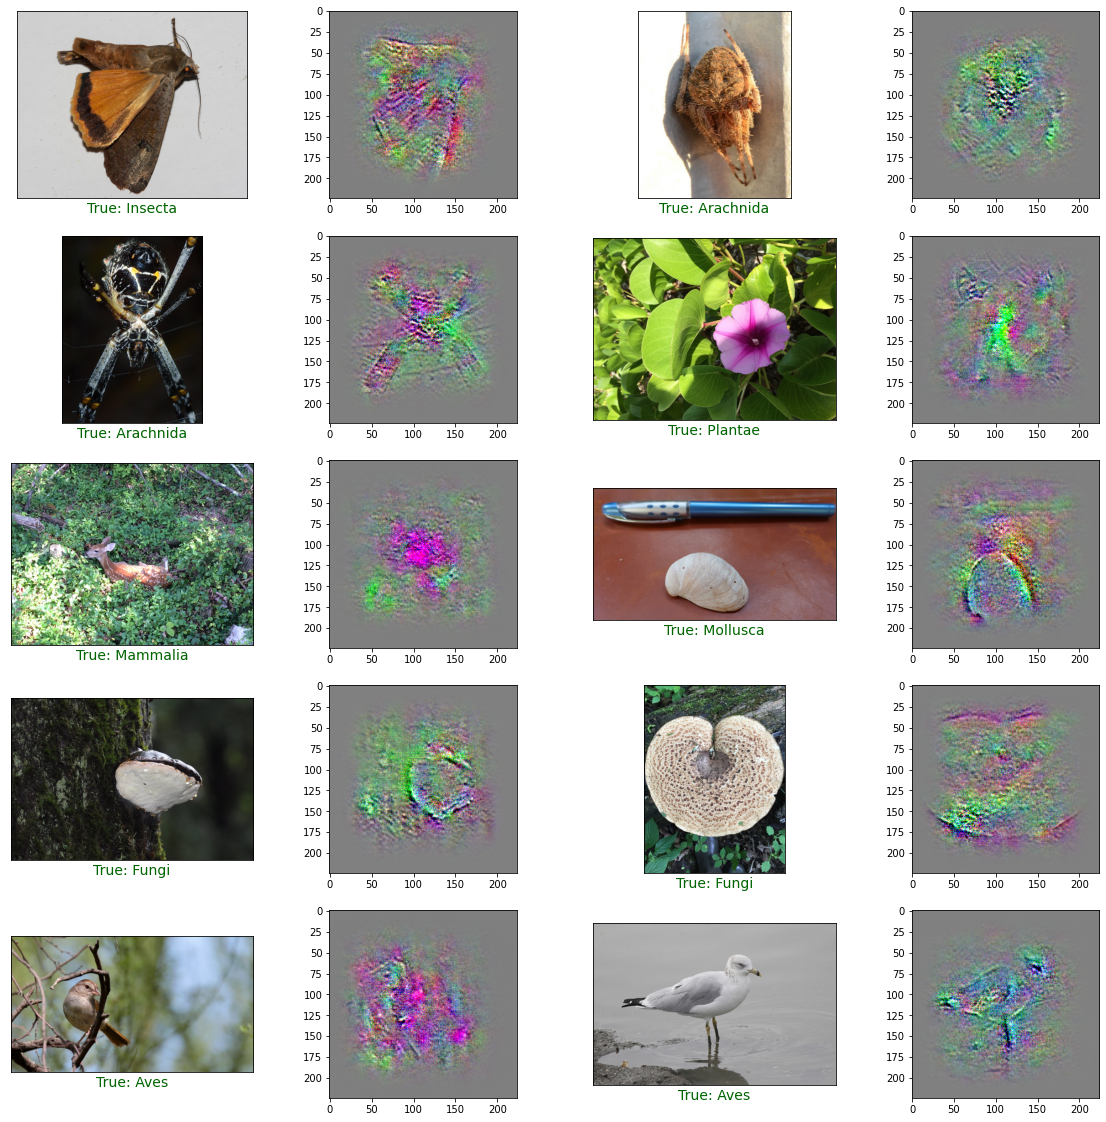

In [ ]:
class guidedBackprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def forward(module, input, output):
            self.activation_maps.append(output)

        def backward(module, inGrad, outGrad):
            grad = self.activation_maps.pop()
            grad[grad > 0] = 1 
            x = torch.clamp(outGrad[0], min=0.0)
            return (x * grad)

        def firstlayer(module, inGrad, outGrad):
            self.image_reconstruction = inGrad[0]


        modules = list(self.model.named_children())

        for ignore, m in modules:
            if isinstance(m, cnn.ReLU):
                module.register_forward_hook(forward)
                module.register_backward_hook(backward)

        firstLayer = modules[0][1]
        firstLayer.register_backward_hook(firstlayer)

    def see(self, input_image, ytrue):
        op = self.model(input_image)
        self.model.zero_grad()
        pred = op.argmax().item()
        
        grad_target_map = torch.zeros(op.shape, dtype=torch.float)
        if ytrue is not None:
            grad_target_map[0][ytrue] = 1
        else:
            grad_target_map[0][pred] = 1
        
        op.backward(grad_target_map)
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

def normalize(nnn):
    norm = (((nnn-nnn.mean())/nnn.std())*0.1+0.5).clip(0, 1)
    return norm

races = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

image_paths=['/content/inaturalist_12K/train/Insecta/0244f93cca6991ab00d792685644f780.jpg',
'/content/inaturalist_12K/train/Arachnida/06cd8c9e2d7902f4bcf12e3ee82f199f.jpg',
'/content/inaturalist_12K/train/Arachnida/0f5ff052d484d403caa0a776a7743bb2.jpg',
'/content/inaturalist_12K/train/Plantae/05a7d3d6c107828e72efead200c6fa5f.jpg',
'/content/inaturalist_12K/train/Mammalia/0dc73e983b22f65eb9ca350d8ad2a4bb.jpg',
'/content/inaturalist_12K/train/Mollusca/0162918c698c3873d807b469f402b29d.jpg',
'/content/inaturalist_12K/train/Fungi/1272588fe81e25ba2de2fc562b1557f1.jpg',
'/content/inaturalist_12K/train/Fungi/29433ad64261a31c000506eb64f8fb8b.jpg',
'/content/inaturalist_12K/train/Aves/050f5913e6f4b7a288544ffff63a113d.jpg',
'/content/inaturalist_12K/train/Aves/50cea217d42965c12fbd2cec62566fb9.jpg']

true_labels=[5, 2, 2, 8, 6, 7, 4, 4, 3, 3]

mu = [0.485, 0.456, 0.406]
sd = [0.229, 0.224, 0.225]
size = 224
transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mu, sd)
        ])
myfig=plt.figure(figsize=(20,20))
for i,image_path in enumerate(image_paths):
    myfig.add_subplot(5, 4, 2*i+1)
    I = Image.open(image_path)
    iimmgg = transform(I).unsqueeze(0).requires_grad_()

    guided_bp = guidedBackprop(cnnModel.cpu())
    result = guided_bp.see(iimmgg, true_labels[i])
    result = normalize(result)
    plt.imshow(IMAGE.imread(image_path))

    plt.xlabel("True: "+ races[true_labels[i]], fontsize=14).set_color('darkgreen')
    plt.xticks([])
    plt.yticks([])
    myfig.add_subplot(5, 4, 2*i+2)
    plt.imshow(result)